In [1]:
import tensorflow as tf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
%matplotlib inline

from IPython.display import Audio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import glob
import csv, pickle, os, sys
import os
import scipy.io.wavfile as wav
import matplotlib
import matplotlib.pyplot as plt
import gzip
import pickle as pkl
from submodules import *
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
filenames = glob.glob('data/data/*')
print(filenames)
vocal_off_filenames = sorted([filename for filename in filenames if 'OffVocal' in filename])
vocal_on_filenames = sorted([filename for filename in filenames if 'OffVocal' not in filename])

['data/data/MujakitoIuNanoSeigi.mp3', 'data/data/KyoumeiShinaiAinoKatachi_OffVocal.mp3', 'data/data/WalkThisWay.mp3', 'data/data/Dearest.mp3', 'data/data/KyoumeiShinaiAinoKatachi.mp3', 'data/data/Stella-rium_OffVocal.mp3', 'data/data/Encounter_OffVocal.mp3', 'data/data/KazegaSaeruyoriHayaku.mp3', 'data/data/RunThroughtheNight_OffVocal.mp3', 'data/data/Reincarnation_OffVocal.mp3', 'data/data/WalkThisWay_OffVocal.mp3', 'data/data/Muketsu_OffVocal.mp3', 'data/data/MujakitoIuNanoSeigi_OffVocal.mp3', 'data/data/Encounter.mp3', 'data/data/KazegaSaeruyoriHayaku_OffVocal.mp3', 'data/data/Sakurakaze_OffVocal.mp3', 'data/data/Sakurakaze.mp3', 'data/data/TanjoubinoKodomotachi_OffVocal.mp3', 'data/data/MahougaUmaretaHi.mp3', 'data/data/TanjoubinoKodomotachi.mp3', 'data/data/ChiyoriUtau_OffVocal.mp3', 'data/data/Muketsu.mp3', 'data/data/Dearest_OffVocal.mp3', 'data/data/MahougaUmaretaHi_OffVocal.mp3', 'data/data/ChiyoriUtau.mp3', 'data/data/SunanoHoshiTrance.mp3', 'data/data/Stella-rium.mp3', 'data

In [4]:
import os
import scipy.io.wavfile as wav

on_lengths = []
off_lengths = []
# install lame
# install bleeding edge scipy (needs new cython)
for filename in vocal_off_filenames:
    fname = filename
    oname = 'temp.wav'
    cmd = 'lame --decode {0} {1}'.format( fname,oname )
    os.system(cmd)
    data = wav.read(oname)
# your code goes here
    print(len(data[1]))
    off_lengths.append(len(data[1]))
for filename in vocal_on_filenames:
    fname = filename
    oname = 'temp.wav'
    cmd = 'lame --decode {0} {1}'.format( fname,oname )
    os.system(cmd)
    data = wav.read(oname)
    on_lengths.append(len(data[1]))
# your code goes here
    print(len(data[1]))

9878400
16786224
12770184
12524400
10274124
13732152
8996400
14008512
11339580
13034196
11263728
10937976
16875012
10300584
10975608
9966600
16873836
12772536
12524400
10274124
13732152
8996400
13993812
11339580
13056540
11243736
10944444
16931460
10299996
10980900


In [6]:
a = np.array([3,5,2])
print(a[[True,True,False]])
idxes = [idx for idx in range(len(on_lengths)) if (on_lengths[idx]-off_lengths[idx])!=0]
print(idxes)
print([vocal_on_filenames[idx] for idx in idxes])
print([on_lengths[idx]-off_lengths[idx] for idx in idxes])

[3 5]
[0, 1, 2, 7, 9, 10, 11, 12, 13, 14]
['data/data/ChiyoriUtau.mp3', 'data/data/Dearest.mp3', 'data/data/Encounter.mp3', 'data/data/Muketsu.mp3', 'data/data/RunThroughtheNight.mp3', 'data/data/Sakurakaze.mp3', 'data/data/Stella-rium.mp3', 'data/data/SunanoHoshiTrance.mp3', 'data/data/TanjoubinoKodomotachi.mp3', 'data/data/WalkThisWay.mp3']
[88200, 87612, 2352, -14700, 22344, -19992, 6468, 56448, -588, 5292]


In [3]:
idx = 6

fname = vocal_on_filenames[idx]
oname = 'temp.wav'
cmd = 'lame --decode {0} {1}'.format( fname,oname )
os.system(cmd)
data_on = wav.read(oname)

fname = vocal_off_filenames[idx]
oname = 'temp.wav'
cmd = 'lame --decode {0} {1}'.format( fname,oname )
os.system(cmd)
data_off = wav.read(oname)


(8996400, 2)


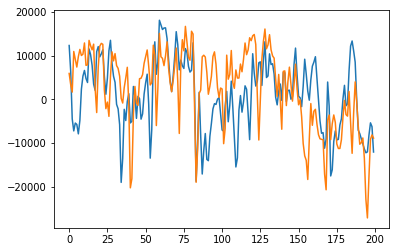

In [4]:
idx_start = 454500
print(data_off[1].shape)
plt.plot(data_on[1][:,1][idx_start:idx_start+200])
plt.plot(data_off[1][:,1][idx_start:idx_start+200])
plt.show()

In [ ]:
Audio(filename=fname)
Audio(data=data_on)
Audio(data=data_off)

In [5]:
class naive_generator(nn.Module):
    def __init__(self):
        super(naive_generator, self).__init__()
        
        self.layer1 = nn.Sequential(convbn_1d(2,32,3,1,1,2), nn.ReLU())
        self.layer2 = nn.Sequential(convbn_1d(32,64,3,1,1,4), nn.ReLU())
        self.layer3 = nn.Sequential(convbn_1d(64,128,3,1,1,8), nn.ReLU())
        self.layer4 = nn.Sequential(convbn_1d(128,256,3,1,1,16), nn.ReLU())
        self.layer5 = nn.Sequential(convbn_1d(256,256,3,1,1,32), nn.ReLU())
        self.layer6 = nn.Sequential(convbn_1d(256,128,3,1,1,1), nn.ReLU())
        self.layer7 = nn.Sequential(convbn_1d(128,32,3,2,1,1), nn.ReLU())
        self.layer8 = nn.Sequential(convbn_1d(32,32,3,2,1,1,transpose=True,output_padding=1), nn.ReLU())
        self.layer9 = nn.Sequential(nn.Conv1d(32,2,3,1,1,1))
        
        self.full = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, \
                                 self.layer6, self.layer7, self.layer8, self.layer9)
        
    def forward(self, x):
        
        out = self.full(x) - x
        
        return out
    
model = naive_generator()
model = nn.DataParallel(model).cuda()

input = torch.randn(50,2,5000).cuda()
print(model.forward(input).shape)
        

TypeError: convbn_1d() got an unexpected keyword argument 'output_padding'

In [22]:
with open('data/test.pkl.gz', 'rb') as f:
    test_data_dict = pkl.load(f)
with open('data/train.pkl.gz', 'rb') as f:
    train_data_dict = pkl.load(f)

{'Dearest.mp3': (array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)), 'KazegaSaeruyoriHayaku.mp3': (array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)), 'KyoumeiShinaiAinoKatachi.mp3': (array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)), 'Encounter.mp3': (array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16))}
dict_keys(['Dearest.mp3', 'KazegaSaeruyoriHayaku.mp3', 'KyoumeiShinaiAinoKatachi.mp3', 'Encounter.mp3'])


In [25]:
train_keys = list(train_data_dict.keys())
x1, x2 = train_data_dict[train_keys[0]]
print(x1.shape)
print(x2.shape)

(11340288,)
(11340288,)


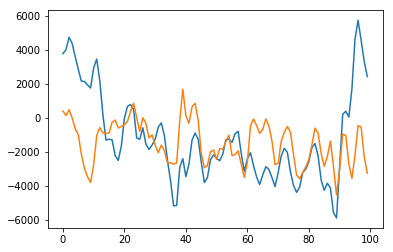

In [35]:
idx = 2340000
plt.plot(x1[idx:idx+100])
plt.plot(x2[idx:idx+100])

In [53]:
import dataloader       
train_dataset = dataloader.KaraokeDataLoader('data/train.pkl.gz')
print(train_dataset.get_random_batch())
print(train_dataset.song_lengths)

test_dataset = dataloader.KaraokeDataLoader('data/test.pkl.gz')
print(test_dataset.get_random_batch())
print(test_dataset.song_lengths)

[DataItem(name='RunThroughtheNight.mp3', start_offset=7322331, length=7056, data=(array([-1276, -2239, -2972, ...,  1313,  1436,   809], dtype=int16), array([-1150, -2385, -3134, ...,  -793,   248,   470], dtype=int16))), DataItem(name='ChiyoriUtau.mp3', start_offset=3682611, length=7056, data=(array([-4956, -5593, -7174, ..., -1288,  -559,  1621], dtype=int16), array([ -209,  -696, -2940, ...,   830,   865,  1665], dtype=int16))), DataItem(name='MujakitoIuNanoSeigi.mp3', start_offset=5450750, length=7056, data=(array([  994,  1522,  1446, ..., -3354,  -980, -1354], dtype=int16), array([  100,  -357,     3, ..., -2315, -2113, -2646], dtype=int16))), DataItem(name='WalkThisWay.mp3', start_offset=1137920, length=7056, data=(array([-5376, -4922, -4173, ...,  3459,  3293,  3124], dtype=int16), array([-2255, -2310, -2054, ...,   576,   256,   580], dtype=int16))), DataItem(name='Stella-rium.mp3', start_offset=7215706, length=7056, data=(array([ 183,  136, -764, ..., -143, -699,  109], dtype

In [71]:
sr=44100
sample_length = utils.FramesToSamples(4 * 100)
on_vocal, off_vocal = utils.Convert16BitToFloat(*train_dataset.get_random_batch(sample_length)[0].data)
on_vocal_mel = utils.MelSpectrogram(on_vocal)
off_vocal_mel = utils.MelSpectrogram(off_vocal)

utils.PlotMel('on vocal', on_vocal_mel)
display(Audio(data=on_vocal, rate=sr))
utils.PlotMel('off vocal', off_vocal_mel)
display(Audio(data=off_vocal, rate=sr))
utils.PlotMel('diff', on_vocal_mel - off_vocal_mel)

NameError: name 'STFT' is not defined